In [2]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.utils import shuffle
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt

In [8]:
def random_initialization(n_components, n_features, X, random_state=None):
    np.random.seed(random_state)
    
    # Initialize pi uniformly
    pi = np.ones(n_components) / n_components
    
    # Initialize means using k-means++ strategy
    indices = [np.random.randint(X.shape[0])]
    mu = [X[indices[0]]]
    
    for k in range(1, n_components):
        distances = np.min([np.sum((X - center) ** 2, axis=1) for center in mu], axis=0)
        probabilities = distances / distances.sum()
        indices.append(np.random.choice(X.shape[0], p=probabilities))
        mu.append(X[indices[-1]])
    
    mu = np.array(mu)
    
    # Initialize covariance matrices using data variance
    data_var = np.var(X, axis=0)
    sigma = []
    for _ in range(n_components):
        cov_matrix = np.diag(data_var)
        sigma.append(cov_matrix)
    sigma = np.array(sigma)
    
    return pi, mu, sigma

def compute_responsibilities(x, pi, mu, sigma, eps=1e-15):
    K = len(pi)
    log_responsibilities = np.zeros(K)
    
    for k in range(K):
        diff = x - mu[k]
        
        # Add small constant to diagonal for numerical stability
        sigma_k = sigma[k] + eps * np.eye(sigma[k].shape[0])
        
        # Compute log probability in a numerically stable way
        log_det = np.log(np.linalg.det(sigma_k))
        inv_sigma = np.linalg.inv(sigma_k)
        exponent = -0.5 * np.dot(diff.T, np.dot(inv_sigma, diff))
        log_responsibilities[k] = np.log(pi[k]) + exponent - 0.5 * (log_det + len(x) * np.log(2 * np.pi))
    
    # Subtract maximum for numerical stability
    log_responsibilities -= np.max(log_responsibilities)
    responsibilities = np.exp(log_responsibilities)
    responsibilities /= np.sum(responsibilities)
    
    return responsibilities

def compute_parameters(mu_stats, n_samples, reg_covar=1e-6):
    pi = np.maximum(mu_stats['N'], 1e-10) / n_samples
    pi /= pi.sum()  # Ensure normalization
    
    mu_k = mu_stats['sum_x'] / mu_stats['N'][:, None]
    
    sigma_k = []
    for k in range(len(pi)):
        cov = mu_stats['sum_xx'][k] / mu_stats['N'][k] - np.outer(mu_k[k], mu_k[k])
        # Ensure positive definiteness
        cov = (cov + cov.T) / 2  # Ensure symmetry
        eigenvalues = np.linalg.eigvalsh(cov)
        if np.any(eigenvalues < reg_covar):
            cov += (reg_covar - np.min(eigenvalues)) * np.eye(cov.shape[0])
        sigma_k.append(cov)
    
    return pi, mu_k, np.array(sigma_k)

def online_incremental_em_gmm(X, n_components=3, T=10, random_state=None, tol=1e-3):
    n_samples, n_features = X.shape
    
    # Step 1: Random initialization
    pi, mu, sigma = random_initialization(n_components, n_features, X, random_state=random_state)
    
    # Step 2: Initialize sufficient statistics
    gamma = np.zeros((n_samples, n_components))
    gamma_x = np.zeros((n_samples, n_components, n_features))
    gamma_xx = np.zeros((n_samples, n_components, n_features, n_features))
    
    mu_stats = {'N': np.zeros(n_components),
                'sum_x': np.zeros((n_components, n_features)),
                'sum_xx': np.zeros((n_components, n_features, n_features))}
    
    prev_log_likelihood = -np.inf
    
    # EM Iterations
    for t in range(T):
        current_log_likelihood = 0
        
        for idx in range(n_samples):
            x_i = X[idx]
            gamma_prime = compute_responsibilities(x_i, pi, mu, sigma)
            
            # Update sufficient statistics
            s_prime_i_gamma = gamma_prime
            s_prime_i_gamma_x = gamma_prime[:, None] * x_i
            s_prime_i_gamma_xx = np.array([gamma_prime[k] * np.outer(x_i, x_i) 
                                         for k in range(n_components)])
            
            # Update global sufficient statistics
            mu_stats['N'] += s_prime_i_gamma - gamma[idx]
            mu_stats['sum_x'] += s_prime_i_gamma_x - gamma_x[idx]
            mu_stats['sum_xx'] += s_prime_i_gamma_xx - gamma_xx[idx]
            
            # Update local statistics
            gamma[idx] = s_prime_i_gamma
            gamma_x[idx] = s_prime_i_gamma_x
            gamma_xx[idx] = s_prime_i_gamma_xx
            
            # Accumulate log likelihood
            current_log_likelihood += np.log(np.sum(gamma_prime))
        
        # Update parameters
        pi, mu, sigma = compute_parameters(mu_stats, n_samples)
        
        # Check convergence
        if abs(current_log_likelihood - prev_log_likelihood) < tol:
            print(f"Converged at iteration {t}")
            break
            
        prev_log_likelihood = current_log_likelihood
    
    return pi, mu, sigma


Converged at iteration 1


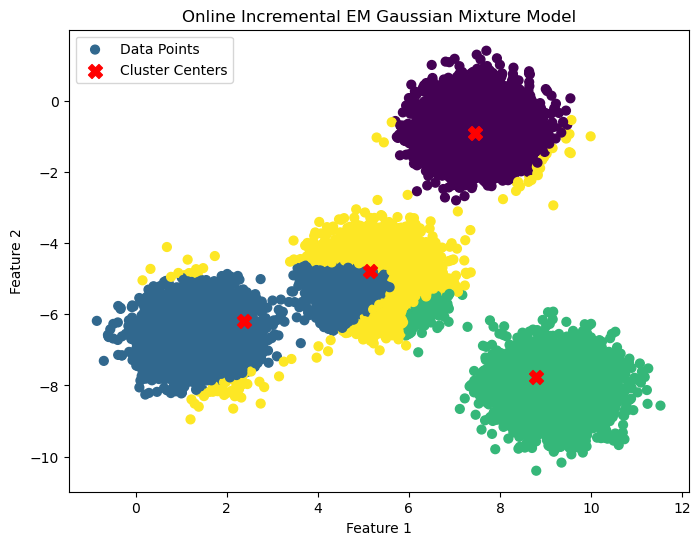

In [17]:
if __name__ == "__main__":
    # Generate synthetic data
    X, y_true = make_blobs(n_samples=20000, centers=4, cluster_std=0.60, random_state=1126)
    
    # Run Online Incremental EM
    n_components = 4
    T = 10
    random_state = 42
    pi, mu_k, sigma_k = online_incremental_em_gmm(X, n_components=n_components, 
                                                 T=T, random_state=random_state)
    
    # Assign clusters
    labels = np.zeros(X.shape[0], dtype=int)
    for i in range(X.shape[0]):
        probs = compute_responsibilities(X[i], pi, mu_k, sigma_k)
        labels[i] = np.argmax(probs)
    
    # Plot results
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', 
                label='Data Points')
    plt.scatter(mu_k[:, 0], mu_k[:, 1], c='red', s=100, marker='X', 
                label='Cluster Centers')
    plt.title('Online Incremental EM Gaussian Mixture Model')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()
